In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from Clustering_Functions import *
from Clustering_Analysis_Functions import *
import itertools
import os
import pickle
import warnings
import math
from matplotlib.ticker import MaxNLocator
from sklearn.manifold import MDS

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
dfK = pd.read_pickle('../clustering_results.pkl') # heuristic results
dfIP = pd.read_json("6_cand_all_solutions.json", orient="records")
# dfIP_PH = pd.read_json("pentland_hills_all_models.json", orient="records")

In [3]:
print(list(dfK.columns))
print(list(dfIP.columns))

['filename', 'num_cands', 'parties', 'method', 'sil', 'cal', 'dav', 'centers', 'bloc size']
['n_candidates', 'election_name', 'model', 'candidates', 'optimum_value', 'centroid_set']


In [4]:
print(dfIP['model'].unique())
print(dfK['method'].unique())

['continuous_bordaP' 'continuous_hh' 'continuous_rest_bordaP'
 'continuous_rest_hh' 'discrete_HH' 'discrete_bordaP']
['Lloyd_Bp' 'Lloyd_Ba' 'Lloyd_H' 'PAM_Bp' 'PAM_Ba' 'PAM_H' 'slate']


In [3]:
# create `df` dataframe to hold IP and heuristic results.

df = pd.DataFrame(columns=['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 
                           'centers', 'proxies_of_centers'])

# add the IP results to df.
D_IP = {
 'continuous_bordaP': ('coords','Borda'),
 'continuous_hh':('coords','HH'),
 'continuous_rest_bordaP':('all','Borda'),
 'continuous_rest_hh':('all','HH'),
 'discrete_HH': ('cast','HH'),
 'discrete_bordaP': ('cast','Borda')}

for index in dfIP.index:
    method, proxy = D_IP[dfIP['model'][index]]
    filename = f"{dfIP['election_name'][index]}.csv" 
    num_cands = dfIP['n_candidates'][index]
    centroids = dfIP['centroid_set'][index]
    technique = f"{method}_{proxy}"
    if technique  == 'cast_HH': # fix that this model uses +- 1/2 for components instead of +-1
        centroids = [ [2*x for x in proxy] for proxy in centroids]
    centers = None
    proxies_of_centers = centroids # all IP data stores centroids in proxy space
    t = df.shape[0]
    df.loc[t] = [filename, num_cands, 2, method, proxy, technique, centers, proxies_of_centers]

# add the heuristic results to df.
filename_list = df['filename'].unique()
D_K = {'Lloyd_Bp': ('Lloyd','Borda'), 'Lloyd_H':('Lloyd','HH'), 'PAM_Bp':('PAM','Borda'), 'PAM_H':('PAM','HH')}
for filename in filename_list:
    for method_code in D_K.keys():
        dfK_sub = dfK[(dfK['filename']==filename) & (dfK['method']==method_code)]
        if dfK_sub.shape[0] == 0:
            continue
        num_cands = dfK_sub['num_cands'].values[0]
        method, proxy = D_K[method_code]
        technique = f"{method}_{proxy}"
        centers = dfK_sub['centers'].values[0]
        centers = [centers[0], centers[1]] # ensure its a list rather than dictionary
        t = df.shape[0]
        if method == 'PAM': 
            df.loc[t] = [filename, num_cands, 2, method, proxy, technique, centers, None]
        else: # For Lloyd, centers live in proxy space
            df.loc[t] = [filename, num_cands, 2, method, proxy, technique, None, centers]

In [5]:
filename_list = df['filename'].unique()
len(filename_list), len(df)//10

(205, 205)

In [7]:
unique_techniques = df['technique'].unique()
for technique in unique_techniques:
    df_sub = df[df['technique']==technique]
    print(technique, df_sub.shape[0])

coords_Borda 205
coords_HH 206
all_Borda 205
all_HH 205
cast_HH 205
cast_Borda 205
Lloyd_Borda 205
Lloyd_HH 205
PAM_Borda 205
PAM_HH 205


In [8]:
df.columns

Index(['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers'],
      dtype='object')

In [ ]:
# add one-cluster centers to df.
count = 1
for filename in filename_list:    
    full_filename = f"../scot-elex/6_cands/{filename}"
    print(count, filename)
    count +=1
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    for method in ['coords', 'cast', 'Lloyd', 'all']:
         for proxy in ['Borda', 'HH']:
            print(f"  {method}_{proxy}")
            c = One_cluster_center(election, method=method, proxy=proxy, borda_style='pes')
            if method == 'coords' or method == 'Lloyd':
                proxies_of_centers = [c]
                centers = None
            else: # method == 'cast' or method == 'all'
                proxies_of_centers = None
                centers = [c]
            technique = f'{method}_{proxy}'
            t = df.shape[0]
            df.loc[t] = [filename, num_cands, 1, method, proxy, technique, centers, proxies_of_centers]

In [7]:
# Find the centers whenever only the proxies of the centers are given
centers_list = []
for index in df.index:
    if df['centers'][index] == None:
        proxies_of_centers = df['proxies_of_centers'][index]
        if df['proxy'][index] == 'Borda':
            centers = [Reverse_Borda(proxy) for proxy in proxies_of_centers]
        elif df['proxy'][index] == 'HH':
            centers = [Reverse_HH(proxy) for proxy in proxies_of_centers]
    else:
        centers = df['centers'][index]
    centers_list.append(centers)

df['centers'] = centers_list

In [8]:
# find their proxies whenever only centers are given
proxies_of_centers_list = []
for index in df.index:
    if df['proxies_of_centers'][index] == None:
        centers = df['centers'][index]
        if df['proxy'][index] == 'Borda':
            proxies_of_centers = [Borda_proxy(center, num_cands=df['num_cands'][index]) for center in centers]
        elif df['proxy'][index] == 'HH':
            proxies_of_centers = [HH_proxy(center, num_cands=df['num_cands'][index]) for center in centers]
    else:
        proxies_of_centers = df['proxies_of_centers'][index]
    proxies_of_centers_list.append(proxies_of_centers)
df['proxies_of_centers'] = proxies_of_centers_list

In [9]:
# For 'all' and 'cast' methods: verify that the centers are simple ballots that match the proxies 

for index in df.index:
    method = df['method'][index]
    if not method in ['all', 'cast']:
        continue
    centers = df['centers'][index]
    proxies_of_centers = df['proxies_of_centers'][index]
    num_cands = df['num_cands'][index]
    proxy_type = df['proxy'][index]
    k = df['k'][index]

    for i in range(k):
        ballot = centers[i]
        if not is_simple(ballot):
            print(f"{num_cands},{method},{proxy_type}: {ballot} is not simple")
        proxy_of_center = proxies_of_centers[i]
        if proxy_type == 'Borda':
            correct_proxy = Borda_proxy(ballot, num_cands, borda_style='pes')
        else:
            correct_proxy = HH_proxy(ballot, num_cands)
            
        if list(proxy_of_center) != list(correct_proxy):
            print(f"{num_cands},{method},{proxy_type}: {ballot} -> {list(correct_proxy)} != {list(proxy_of_center)}")

In [38]:
# (for 'coords' and 'Lloyd' methods): for each proxy type, find portion of ballot proxies that 
# correspond to: simple ballots, generalized ballots, none.
# For the simple and generalized categories, check if they exactly correspond to ballots.

for meth in ['Lloyd', 'coords']:
    for k in [1,2]:
        simple_match_counts = {proxy:0 for proxy in ['Borda','HH']}
        simple_unmatch_counts = {proxy:0 for proxy in ['Borda','HH']}
        gen_match_counts = {proxy:0 for proxy in ['Borda','HH']}
        gen_unmatch_counts = {proxy:0 for proxy in ['Borda','HH']}
        none_counts = {proxy:0 for proxy in ['Borda','HH']}
        total = {proxy:0 for proxy in ['Borda','HH']}
        for index in df.index:
            method = df['method'][index]
            if method != meth:
                continue
            if df['k'][index] != k:
                continue
            centers = df['centers'][index]
            proxies_of_centers = df['proxies_of_centers'][index]
            num_cands = df['num_cands'][index]
            proxy_type = df['proxy'][index]

            for i in range(k):
                total[proxy_type] += 1
                ballot = centers[i]
                if ballot == None:
                    none_counts[proxy_type] += 1
                    continue
                is_this_simple = is_simple(ballot)
                proxy_of_center = proxies_of_centers[i]
                if proxy_type == 'Borda':
                    correct_proxy = Borda_proxy(ballot, num_cands, borda_style='pes')
                else:
                    correct_proxy = HH_proxy(ballot, num_cands)
                if list(proxy_of_center) == list(correct_proxy):
                    if is_this_simple:
                        simple_match_counts[proxy_type] += 1
                    else:
                        gen_match_counts[proxy_type] += 1
                else:
                    if is_this_simple:
                        simple_unmatch_counts[proxy_type] += 1
                    else:
                        gen_unmatch_counts[proxy_type] += 1

        print(f"SUMMARY for '{meth}' method, k={k}:")
        print(f'simple match counts:\t Borda: {simple_match_counts["Borda"]/total["Borda"]:.1%}, HH: {simple_match_counts["HH"]/total["HH"]:.1%}')
        print(f'simple unmatch counts:\t Borda: {simple_unmatch_counts["Borda"]/total["Borda"]:.1%}, HH: {simple_unmatch_counts["HH"]/total["HH"]:.1%}')
        print(f'gen match counts:\t Borda: {gen_match_counts["Borda"]/total["Borda"]:.1%}, HH: {gen_match_counts["HH"]/total["HH"]:.1%}')
        print(f'gen unmatch counts:\t Borda: {gen_unmatch_counts["Borda"]/total["Borda"]:.1%}, HH: {gen_unmatch_counts["HH"]/total["HH"]:.1%}')
        print(f'none counts:\t\t Borda: {none_counts["Borda"]/total["Borda"]:.1%}, HH: {none_counts["HH"]/total["HH"]:.1%}')
        print('\n')

SUMMARY for 'Lloyd' method, k=1:
simple match counts:	 Borda: 0.0%, HH: 0.0%
simple unmatch counts:	 Borda: 100.0%, HH: 97.1%
gen match counts:	 Borda: 0.0%, HH: 0.0%
gen unmatch counts:	 Borda: 0.0%, HH: 0.0%
none counts:		 Borda: 0.0%, HH: 2.9%


SUMMARY for 'Lloyd' method, k=2:
simple match counts:	 Borda: 0.0%, HH: 0.0%
simple unmatch counts:	 Borda: 100.0%, HH: 99.8%
gen match counts:	 Borda: 0.0%, HH: 0.0%
gen unmatch counts:	 Borda: 0.0%, HH: 0.0%
none counts:		 Borda: 0.0%, HH: 0.2%


SUMMARY for 'coords' method, k=1:
simple match counts:	 Borda: 1.0%, HH: 31.2%
simple unmatch counts:	 Borda: 47.8%, HH: 0.0%
gen match counts:	 Borda: 10.7%, HH: 11.2%
gen unmatch counts:	 Borda: 40.5%, HH: 0.5%
none counts:		 Borda: 0.0%, HH: 57.1%


SUMMARY for 'coords' method, k=2:
simple match counts:	 Borda: 32.7%, HH: 62.6%
simple unmatch counts:	 Borda: 15.1%, HH: 0.0%
gen match counts:	 Borda: 41.2%, HH: 14.3%
gen unmatch counts:	 Borda: 11.0%, HH: 0.0%
none counts:		 Borda: 0.0%, HH: 23.

INTERPRETATIONS:

$95$ of the $205\cdot 2= 410$ HH proxy vectors are inconsistent (have loops like A>B>C>A).  Of the rest, $258$ pull back to simple ballots and $59$ to generalized ballots.  For a sanity check, we verified that these are uniquely determined by the (simple or generalized) ballot to which they pull back.

About half ($214$) of the Borda proxies have ties (multiple occurances of the same number, other than in last place), so they correspond to generalized (rather than simple) ballots.  About a quarter of the Borda proxies aren't valid proxies of actual ballots, since component-wise medians don't necessarily follow the rules.

In [2]:
def Summarize_centers(filename, k=2, proxies = ['Borda','HH'], methods = ['Lloyd','coords', 'cast']):
    print(f"\n Filename: {filename}, k={k}")
    df_sub = df[(df['filename']==filename) & (df['k']==k)]
    for proxy, method in [(p,m) for p in proxies for m in methods]:
        df_subsub = df_sub[(df_sub['proxy']==proxy) & (df_sub['method']==method)]
        if df_subsub.shape[0] == 0:
            continue
        centers = df_subsub['centers'].values[0]
        proxies_of_centers = df_subsub['proxies_of_centers'].values[0]
        
        matched = ['~', '~'] 
        for i in range(len(centers)):
            ballot = centers[i]
            if ballot is None:
                matched[i] = ' '
                continue
            proxy_of_center = proxies_of_centers[i]
            if proxy == 'Borda':
                correct_proxy = Borda_proxy(ballot, num_cands=df_subsub['num_cands'].values[0], borda_style='pes')
            else:
                correct_proxy = HH_proxy(ballot, num_cands=df_subsub['num_cands'].values[0])
            if list(proxy_of_center) == list(correct_proxy):
                matched[i] = '='
        print(f"{method}, {proxy}:", end ='')
        for i in range(len(centers)):
            print(f" {matched[i]}{centers[i]}", end=' ')
        print()

In [11]:
filename = random.choice(filename_list)
Summarize_centers(filename, k=1)
Summarize_centers(filename, k=2)


 Filename: falkirk_2022_ward5.csv, k=1
Lloyd, Borda: ~(1, 5, 2, 4, 3, 6) 
coords, Borda: ~({1, 5}, {2}, {3, 4, 6}) 
cast, Borda: =(1,) 
Lloyd, HH: ~(1, 2, 4, 5, 6, 3) 
coords, HH: =() 
cast, HH: =(1,) 

 Filename: falkirk_2022_ward5.csv, k=2
Lloyd, Borda: ~(2, 4, 6, 1, 5, 3)  ~(5, 1, 3, 6, 2, 4) 
coords, Borda: ~({2, 4}, {6}, {1, 3, 5})  ~({1, 3, 5}, {2, 4, 6}) 
cast, Borda: =(2, 4, 6)  =(1, 5, 3) 
Lloyd, HH: ~(1, 5, 3, 6, 2, 4)  ~(2, 4, 6, 1, 5, 3) 
coords, HH: =({1, 3, 5}, {2, 4, 6})   None 
cast, HH: =(1, 5, 3)  =(2, 4, 6) 


In [31]:
# for each proxy method, determine the portion of elections for which the 'all' centers 
# correspond to ballots that were actually cast in the election.
# and identify elections where the 'all' centers are () the empty ballot.

elections_with_uncast_centers = dict()
elections_with_empty_centers = dict()
for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    if method != 'all':
        continue
    centers = df['centers'][index]
    proxies_of_centers = df['proxies_of_centers'][index]
    num_cands = df['num_cands'][index]
    k = df['k'][index]
    filename = df['filename'][index]
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    for center in centers:
        if center == ():
            elections_with_empty_centers[(k, proxy)] = elections_with_empty_centers.get((k, proxy), []) + [filename]
        elif not center in election.keys():
            elections_with_uncast_centers[(k, proxy)] = elections_with_uncast_centers.get((k, proxy), []) + [filename]
print("elections with empty centers:")
for key, ls in elections_with_empty_centers.items():
    print(f" k={key[0]}, proxy={key[1]}: {(len(ls))} of elections")
print("elections with uncast centers:")
print(elections_with_uncast_centers)

elections with empty centers:
 k=1, proxy=Borda: 72 of elections
 k=1, proxy=HH: 88 of elections
elections with uncast centers:
{}


INTERPRETATION:

With the 'all' method, empty centers only happen for k=1.

With the exception of empty centers, the 'all' method always produces cast centers, so the method isn't really more general, at least among 6-candidate elections.


In [30]:
# How frequently do 'cast' centers match 'all' centers
# (among the elections for which the 'all' center is not the empty ballot)  
for k in [1,2]:
    print(f"\n k={k}:")
    good_counts = {proxy:0 for proxy in ['Borda', 'HH']}
    bad_counts = {proxy:0 for proxy in ['Borda', 'HH']}

    for index in df.index:
        if df['method'][index] != 'all':
            continue
        if df['k'][index] != k:
            continue
        filename = df['filename'][index]
        rest_centers = df['centers'][index]
        if rest_centers[0] == ():
            continue
        proxy = df['proxy'][index]
        row_index = df[(df['filename'] == filename) & (df['k'] == k) & (df['technique'] == f'cast_{proxy}')].index[0]
        discrete_centers = df['centers'][row_index]
        if set(rest_centers) != set(discrete_centers):
            #print(f"{filename} ({proxy}): {rest_centers[0],rest_centers[1]} != {discrete_centers[0],discrete_centers[1]}")
            bad_counts[proxy] += 1
        else:
            good_counts[proxy] += 1

    # portion of the elections for which the 'all' centers match the 'cast' centers
    good_counts = {proxy:count for proxy,count in good_counts.items()}
    bad_counts = {proxy:count for proxy,count in bad_counts.items() }
    print({proxy:good_counts[proxy]/(good_counts[proxy]+bad_counts[proxy]) for proxy in good_counts.keys()})


 k=1:
{'Borda': 1.0, 'HH': 1.0}

 k=2:
{'Borda': 1.0, 'HH': 1.0}


INTERPRETATION:

The 'cast' centers always match the 'all' centers (unless the 'all' center is the empty ballot), even though there are presumably tied solutions that might be found..

In [ ]:
#df.to_pickle('combined_clustering_centers.pkl')

In [3]:
df = pd.read_pickle('combined_clustering_centers.pkl')

In [27]:
# Compute the score (summed L^1 or L^2 distance of the ballots to the nearest center) for all the methods and all proxies.
# and rebuild all of the clusterings from the centers.
score_list = []
clusters_list = []
for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)

    centers = df['proxies_of_centers'][index]
    order = 2 if method == 'Lloyd' else 1

    score, clustering = Clusters_from_centers(election, centers, proxy, order=order, 
                                              centers_live_in_proxy_space=True)
    score_list.append(score)
    clusters_list.append(clustering)
df['score'] = score_list
df['clustering'] = clusters_list

In [13]:
# add column for the size of the smaller of the clusters
smallest_cluster_sizes = []
for index in df.index:
    clustering = df['clustering'][index]
    cluster_sizes = [sum(clustering[cluster].values()) for cluster in clustering.keys()]
    smallest_cluster_sizes.append(min(cluster_sizes)/sum(cluster_sizes))
df['smallest_cluster_size'] = smallest_cluster_sizes

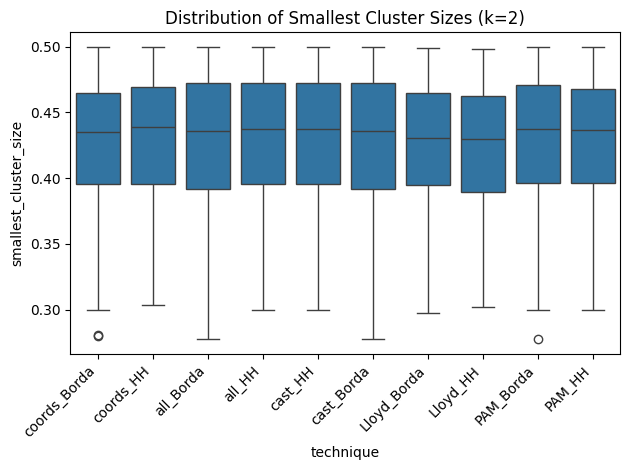

In [15]:
ax = sns.boxplot(data=df[df['k']==2], x='technique', y='smallest_cluster_size')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution of Smallest Cluster Sizes (k=2)')
plt.tight_layout()
plt.savefig('smallest_cluster_size_distribution_k2.png', dpi=300)
plt.show()

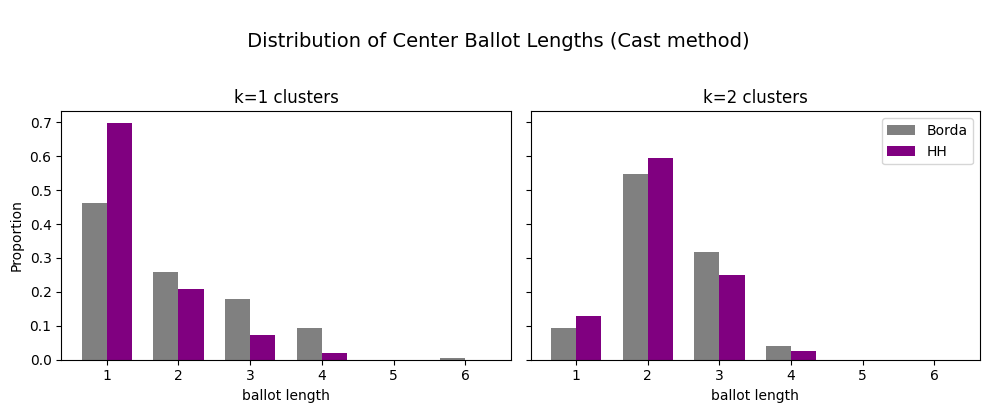

In [9]:
# find distribution of the lengths of the centers from the 'cast' method (k=1 and k=2 side-by-side)
num_cands = 6
X = np.arange(num_cands)
width = .7/2
palat = ['grey', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, k_ in zip(axes, [1, 2]):
    for i, proxy in enumerate(['Borda', 'HH']):
        Y = np.zeros(num_cands)
        count = 0
        df_sub = df[(df['method'] == 'cast') & (df['proxy'] == proxy) & (df['k'] == k_)]
        for idx in df_sub.index:
            centers = df_sub['centers'][idx]
            for center in centers:
                Y[len(center) - 1] += 1
                count += 1
        if count > 0:
            Y = Y / count
        ax.bar(X + (i-.5) * width, Y, width=width, label=f"{proxy}", color=palat[i])

    ax.set_title(f'k={k_} clusters')
    ax.set_xlabel('ballot length')
    ax.set_xticks(X)
    ax.set_xticklabels(X + 1)
fig.suptitle('\n Distribution of Center Ballot Lengths (Cast method)', fontsize=14, y=1.02)
axes[0].set_ylabel('Proportion')
axes[1].legend()
plt.tight_layout()
plt.savefig('center_ballot_length_distribution.png', dpi=300)
plt.tight_layout()
plt.show()

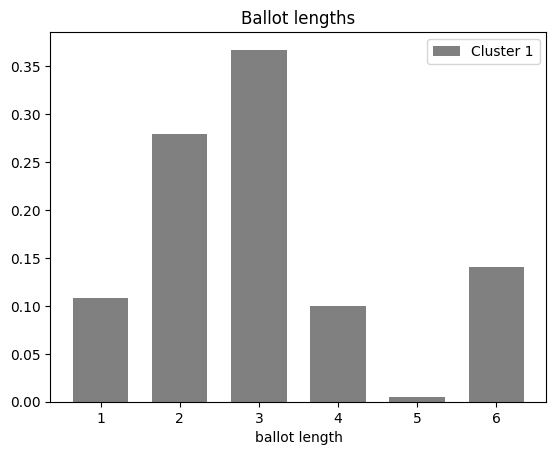

In [114]:
# plot the distribution of the lenghts of the ballots in one randomly chosen election
filename = random.choice(filename_list)
full_filename = f"../scot-elex/6_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)

Plot_ballot_lengths(election)

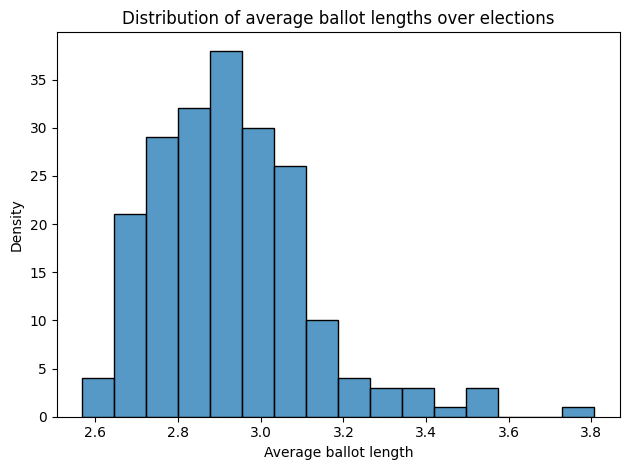

In [95]:
# plot the distribution (over the elections) of the average length of all the ballots the elections
average_ballot_lengths = []
for filename in filename_list:
    full_filename = f"../scot-elex/6_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    total_length = 0
    total_weight = 0
    for ballot, weight in election.items():
        total_length += len(ballot) * weight
        total_weight += weight
    average_length = total_length / total_weight
    average_ballot_lengths.append(average_length)

sns.histplot(average_ballot_lengths)
plt.xlabel('Average ballot length')
plt.ylabel('Density')
plt.title('Distribution of average ballot lengths over elections')
plt.tight_layout()
plt.show()  

In [119]:
df['method'].unique()

array(['coords', 'all', 'cast', 'Lloyd', 'PAM'], dtype=object)

In [33]:
# count elections for a center is the empty ballot ()
for k in [1,2]:
    empty_count = pd.DataFrame(columns = ['Borda','HH'], index = ['Lloyd','coords'])
    for method in ['Lloyd','coords']:
        row = {}
        for proxy in ['Borda','HH']:
            df_sub = df[(df['method']==method) & (df['proxy']==proxy) & (df['k']==k)]
            count = 0
            for index in df_sub.index:
                centers = df_sub['centers'][index]
                if centers[0] == () or (k==2 and centers[1] == ()):
                    count += 1
                    if proxy == 'Borda':
                        print(f"{df_sub['filename'][index]} has empty ballot as center (Borda)")
                        print(df_sub['proxies_of_centers'][index], '\n')
            row[proxy] = count
        empty_count.loc[method] = row

    print(f"Number of elections with empty ballot as center (k={k}):")
    print(empty_count)
    print("\n")

sc_borders_2012_ward2.csv has empty ballot as center (Borda)
[array([0., 0., 0., 0., 0., 0.])] 

Number of elections with empty ballot as center (k=1):
       Borda  HH
Lloyd      0   0
coords     1  42


Number of elections with empty ballot as center (k=2):
       Borda HH
Lloyd      0  0
coords     0  0




In [ ]:
# Sanity check: Verify that the computed score matches the one from the IP solver dataframe dfIP.
D_IP_reverse = {v:k for k,v in D_IP.items()}

IP_techniques = ['coords_Borda', 'coords_HH', 'all_Borda', 'all_HH', 'cast_HH', 'cast_Borda']
Good_counts = {technique:0 for technique in IP_techniques}
Bad_counts = {technique:0 for technique in IP_techniques}

for index in df.index:
    method = df['method'][index]
    proxy = df['proxy'][index]
    filename = df['filename'][index]
    technique = df['technique'][index]
    if method not in ['all', 'cast', 'coords']:
        continue
    row_index = dfIP[(dfIP['election_name'] == filename[:-4]) & (dfIP['model'] == D_IP_reverse[(method, proxy)])].index[0]
    IP_score = dfIP['optimum_value'][row_index]
    if method in ['all', 'coords'] or technique == 'cast_Borda':
        IP_score *= (1/2) # divide by 2 to match our score definition as half the L^1 distance
    computed_score = df['score'][index]
    if abs(IP_score - computed_score) > 1e-6:
        print(f"Score mismatch for {filename}, ({technique}): ratio ={IP_score/computed_score}")
        Bad_counts[technique] += 1
    else:   
        Good_counts[technique] += 1
        
if sum(Bad_counts.values()) == 0:
    print("All scores match!")

All scores match!


In [17]:
# find portion of elections for which the cast centers match the PAM centers
# when they don't, check whether the cast centers tie or score better.
match_count = {'Borda':0, 'HH':0}
unmatch_count = {'Borda':0, 'HH':0}

tie_count = {'Borda':0, 'HH':0}
PAM_win_count = {'Borda':0, 'HH':0}
cast_win_count = {'Borda':0, 'HH':0}

row_index = 0
for index in df.index:
    if df['method'][index] != 'cast':
        continue
    discrete_centers = df['centers'][index]
    discrete_score = df['score'][index]
    filename = df['filename'][index]
    proxy_type = df['proxy'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'PAM_{proxy_type}')].index[0]
    PAM_score = df['score'][row_index]
    PAM_centers = df['centers'][row_index]
    if set(PAM_centers) == set(discrete_centers):
        match_count[proxy_type] += 1
        continue
    else:
        unmatch_count[proxy_type] += 1
    
    if discrete_score == PAM_score:
        tie_count[proxy_type] += 1
        print("TIE: ",filename, proxy_type)
    elif discrete_score < PAM_score:
        cast_win_count[proxy_type] += 1
    else:
        PAM_win_count[proxy_type] += 1
        print(proxy_type, discrete_score, PAM_score, discrete_centers, PAM_centers)

print(f'match: {match_count}')
print(f'unmatch but tie: {tie_count}')
print(f'PAM win: {PAM_win_count}')
print(f'"cast" win: {cast_win_count}')

TIE:  east_dunbartonshire_2017_ward5.csv HH
match: {'Borda': 189, 'HH': 194}
unmatch but tie: {'Borda': 0, 'HH': 1}
PAM win: {'Borda': 0, 'HH': 0}
"cast" win: {'Borda': 16, 'HH': 10}


In [16]:
# Look at the one election in which PAM and 'cast' tie but don't match
filename = 'east_dunbartonshire_2017_ward5.csv'
full_filename = f"../ballot-clustering/scot-elex/{num_cands}_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)
test = df[(df['filename'] == filename) & (df['technique'].isin(['cast_HH', 'PAM_HH']))][['technique', 'centers', 'score', 'clustering']]
test

,technique,centers,score,clustering
370,cast_HH,"[(4, 5, 1), (3, 6, 2)]",19880.0,"{0: {(1,): 43.0, (1, 2): 5.0, (1, 2, 4): 2.0, ..."
1478,PAM_HH,"[(2, 3, 6), (4, 5, 1)]",19880.0,"{0: {(1, 2): 5.0, (1, 2, 3): 3.0, (1, 2, 3, 6)..."


In [ ]:
C1 = test['clustering'][370]
C2 = test['clustering'][1478]
Clustering_closeness(election, C1, C2)

INTERPETATION:

PAM centers match 'cast' centers over $90\%$ of the time.  When they don't match, there's only one election (with HH) for which the reason is that they find different tied optimum (the centers are slightly different and result in slightly different clusterings).  For the rest, it's because 'cast' beats PAM.

In [23]:
# determine the portion of the elections for which the continous score beats the cast score
tie_counts = {proxy:0 for proxy in ['Borda', 'HH']}
continuous_win_counts = {proxy:0 for proxy in ['Borda', 'HH']}
discrete_win_counts = {proxy:0 for proxy in ['Borda', 'HH']}

for index in df.index:
    if df['method'][index] != 'coords':
        continue
    filename = df['filename'][index]
    proxy_type = df['proxy'][index]
    continuous_score = df['score'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'cast_{proxy_type}')].index[0]
    discrete_score = df['score'][row_index]

    if continuous_score == discrete_score:
        tie_counts[proxy_type] += 1
    elif continuous_score < discrete_score:
        continuous_win_counts[proxy_type] += 1
    else:
        discrete_win_counts[proxy_type] += 1

tie_counts, continuous_win_counts, discrete_win_counts

({'Borda': 22, 'HH': 78}, {'Borda': 183, 'HH': 128}, {'Borda': 0, 'HH': 0})

In [44]:
# measure clustering closness of the cast vs continuous methods
closeness = {proxy:[] for proxy in ['Borda', 'HH']}
errors = 0

for index in df.index:
    if df['method'][index] != 'coords':
        continue
    filename = df['filename'][index]
    proxy_type = df['proxy'][index]
    C_continuous = df['clustering'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'cast_{proxy_type}')].index[0]
    C_discrete = df['clustering'][row_index]

    num_cands = df['num_cands'][index]
    full_filename = f"../ballot-clustering/scot-elex/{num_cands}_cands/{filename}"
    _, election, __, ____ = csv_parse(full_filename)
    try:
        closeness[proxy_type].append(Clustering_closeness(election, C_continuous, C_discrete))
    except:
        errors += 1
        print(proxy, filename)

In [45]:
{proxy: np.mean(closeness[proxy]) for proxy in closeness.keys()}

{'Borda': 0.03241625811392328, 'HH': 0.02020563301256821}

In [95]:
#count the simple and generalized ballots for 6 candidates
counter = 0
for ballot in all_possible_ballots(6, include_empty_ballot=True, include_generalized_ballots=False):
    counter += 1 
print("number of simple ballots for 6 candidates:", counter)
counter = 0
for ballot in all_possible_ballots(6, include_empty_ballot=True, include_generalized_ballots=True):
    counter += 1 
print("number of generalized ballots for 6 candidates:", counter)

number of simple ballots for 6 candidates: 1957
number of generalized ballots for 6 candidates: 4683


In [ ]:
# For coords method, create columns for:
# 'actual_dist' = distance from center to closest proxy of an actual ballot
# 'gen_dist' = distance from center to closest proxy of a generalized ballot
# 'cast_dist' = distance from center to closest proxy of a cast ballot
# (all are lists of length 2, one per center)
df_coords = df[df['method']=='coords'].copy()

actual_dist_list = []
gen_dist_list = []
cast_dist_list = []

for index in df_coords.index:
    filename = df_coords['filename'][index]
    proxies_of_centers = df_coords['proxies_of_centers'][index]
    proxy_type = df_coords['proxy'][index]
    k = df_coords['k'][index]
    print(filename, proxy_type, k)
    df_cast = df[(df['filename']==filename) & (df['method']=='cast') & (df['proxy']==proxy_type)]
    cast_centers = df_cast['centers'].values[0]

    actual_dist = []
    gen_dist = []
    for proxy in proxies_of_centers:
        dist = Dist_to_closest_ballot(proxy, proxy_type)
        actual_dist.append(dist)
        dist = Dist_to_closest_ballot(proxy, proxy_type, include_generalized_ballots=True)
        gen_dist.append(dist)
    actual_dist_list.append(actual_dist)
    gen_dist_list.append(gen_dist)

    cast_dist = []
    for proxy in proxies_of_centers:
        closest_dist = float('inf')
        for center in cast_centers:
            if proxy_type == 'Borda':
                d = np.linalg.norm(proxy - Borda_proxy(center, num_cands=6), ord=1)
            else:
                d = np.linalg.norm(proxy - HH_proxy(center, num_cands=6), ord=1)
            if d < closest_dist:
                closest_dist = d
        cast_dist.append(closest_dist)
    cast_dist_list.append(cast_dist)

df_coords['actual_dist'] = actual_dist_list
df_coords['gen_dist'] = gen_dist_list
df_coords['cast_dist'] = cast_dist_list

In [4]:
# df_coords.to_pickle('coords_centers_distances.pkl')
df_coords = pd.read_pickle('coords_centers_distances.pkl')

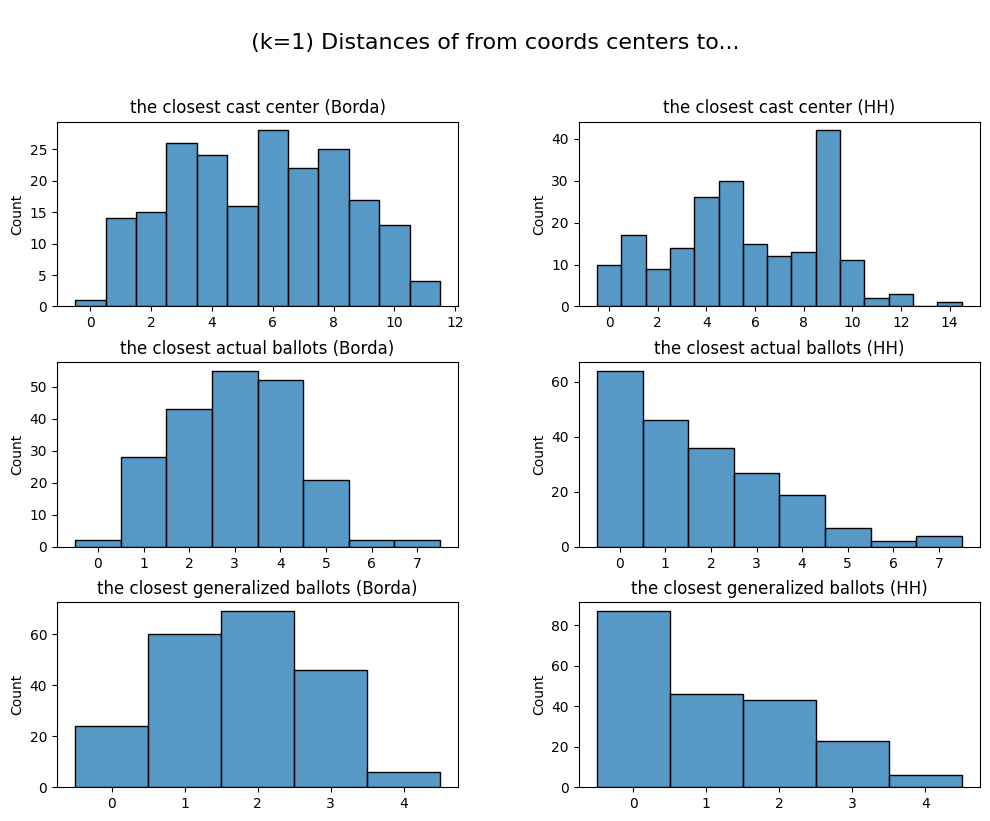

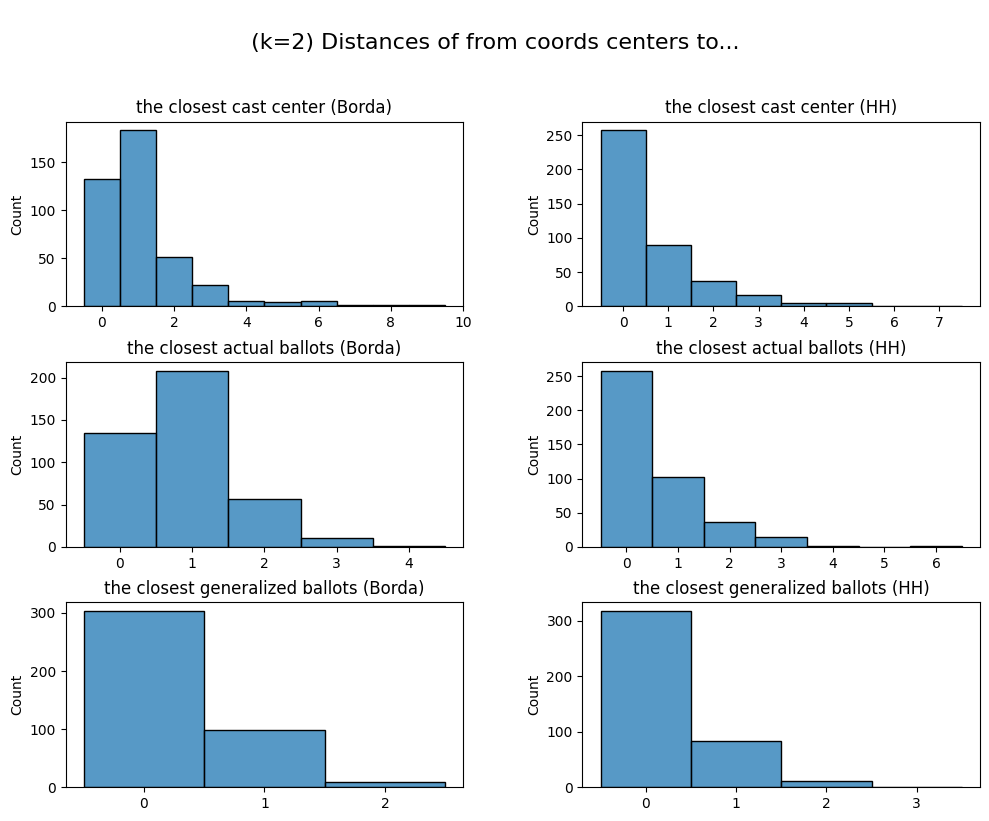

In [92]:
for K in [1,2]:
    distances_to_actual_ballots = {'Borda':[], 'HH':[]}
    distances_to_gen_ballots = {'Borda':[], 'HH':[]}
    distances_to_cast_ballots = {'Borda':[], 'HH':[]}
    for index in df_coords.index:
        k = df_coords['k'][index]
        if k != K:
            continue
        if df_coords['actual_dist'][index] is None:
            continue
        proxy_type = df_coords['proxy'][index]
        for d in df_coords['actual_dist'][index]:
            distances_to_actual_ballots[proxy_type].append(d)
        for d in df_coords['gen_dist'][index]:
            distances_to_gen_ballots[proxy_type].append(d)
        for d in df_coords['cast_dist'][index]:
            distances_to_cast_ballots[proxy_type].append(d)

    fig, axes = plt.subplots(3, 2, figsize=(10, 8))

    for i, proxy_type in enumerate(['Borda', 'HH']):
        sns.histplot(
            distances_to_cast_ballots[proxy_type],
            ax=axes[0, i],
            discrete=True
        )
        axes[0, i].set_title(f'the closest cast center ({proxy_type})')

    for i, proxy_type in enumerate(['Borda', 'HH']):
        sns.histplot(
            distances_to_actual_ballots[proxy_type],
            ax=axes[1, i],
            discrete=True
        )
        axes[1, i].set_title(f'the closest actual ballots ({proxy_type})')
        
    for i, proxy_type in enumerate(['Borda', 'HH']):
        sns.histplot(
            distances_to_gen_ballots[proxy_type],
            ax=axes[2, i],
            discrete=True
        )
        axes[2, i].set_title(f'the closest generalized ballots ({proxy_type})')

    # Force integer x-ticks only
    for ax in axes.flat:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.suptitle(f'\n (k={K}) Distances of from coords centers to... ', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig(f'coords_centers_distance_to_ballots_k{K}.png', dpi=300)
    plt.show()


In [5]:
def Centers_MDS(filename, method = 'coords', proxy_type='HH', order=1, label_ballots = False):
    """
    Create a 2D MDS plot of the following points in proxy space:
    - origin (0 vector)
    - center for k=1
    - two centers for k=2
    ARGS:
    filename: str, the election filename
    method: str, one of {'coords', 'cast', 'Lloyd', 'all'}
    proxy_type: str, one of {'Borda', 'HH'}
    order: int, 1 or 2, the L^order norm to use for distance calculations
    """
    df_sub = df[(df['filename']==filename) & (df['proxy']==proxy_type) & (df['method']==method)]
    df_sub1 = df_sub[df_sub['k']==1]
    C0 = df_sub1['proxies_of_centers'].values[0][0]
    C0_ballot = df_sub1['centers'].values[0][0]
    df_sub2 = df_sub[df_sub['k']==2]
    CA,CB = df_sub2['proxies_of_centers'].values[0]
    CA_ballot, CB_ballot = df_sub2['centers'].values[0]
    proxy_dim = len(C0)
    origin = np.zeros(proxy_dim)
    points = np.array([origin, C0, CA, CB])
    labels = ['0', f'{C0_ballot}', f'{CA_ballot}', f'{CB_ballot}'] if label_ballots else ['0', 'C1', 'C2A', 'C2B']
    dist_matrix = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            dist_matrix[i,j] = np.linalg.norm(points[i]-points[j], ord=order)
    model = MDS(n_components=2, dissimilarity='precomputed', n_init = 500, metric = True)
    projections = model.fit_transform(dist_matrix)
    error = model.stress_
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) 
    s = 200*np.array([1, 1, 1, 1]) # scale for point sizes
    c = ['black', 'red', 'blue', 'blue']  # colors for points
    fig, ax = plt.subplots( figsize=(3,3))
    ax.scatter(X,Y, c = c, s = s, alpha=.5)

    x_margin = (max(X) - min(X)) * 0.2  # 20% margin
    plt.xlim(min(X) - x_margin, max(X) + x_margin)
    y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
    plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
    for count, label in enumerate(labels):
        ax.annotate(label, xy=(X[count], Y[count]))
    ax.grid(False)
    ax.axis('off')
    plt.show()

In [6]:
filename_list = df['filename'].unique()

east_dunbartonshire_2022_ward1.csv
    coords, Borda


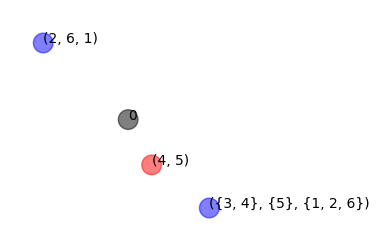

    coords, HH


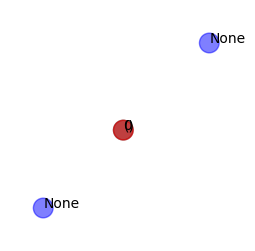

    Lloyd, Borda


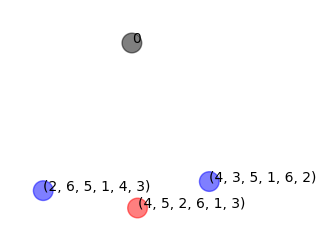

    Lloyd, HH


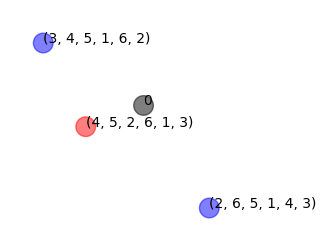

    cast, Borda


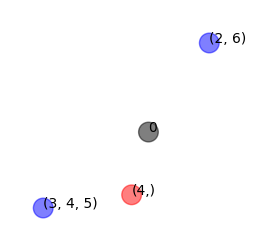

    cast, HH


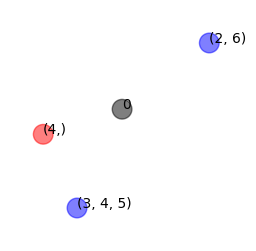

    all, Borda


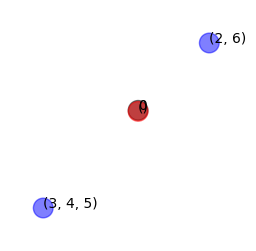

    all, HH


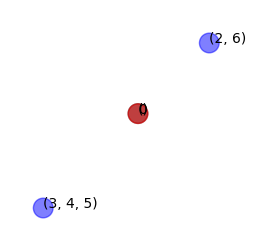

In [8]:
filename = random.choice(filename_list)
print(filename)
for method in ['coords', 'Lloyd', 'cast', 'all']:
    for proxy in ['Borda', 'HH']:
        print(f"    {method}, {proxy}")
        Centers_MDS(filename, method, proxy, label_ballots=True)

sc_borders_2017_ward10.csv


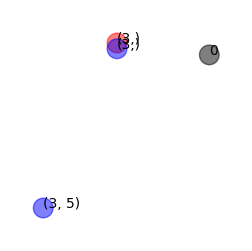

In [15]:
for _ in range(1):
    filename = random.choice(filename_list)
    print(filename)
    Centers_MDS(filename, 'coords', 'Borda', label_ballots=True)

In [17]:
Summarize_centers(filename, k=1)
Summarize_centers(filename, k=2)


 Filename: sc_borders_2017_ward10.csv, k=1
Lloyd, Borda: ~(3, 5, 6, 4, 2, 1) 
coords, Borda: =(3,) 
cast, Borda: =(3,) 
Lloyd, HH: ~(3, 5, 6, 4, 2, 1) 
coords, HH: =(3,) 
cast, HH: =(3,) 

 Filename: sc_borders_2017_ward10.csv, k=2
Lloyd, Borda: ~(5, 3, 6, 1, 2, 4)  ~(3, 4, 6, 2, 1, 5) 
coords, Borda: =(3, 5)  =(3,) 
cast, Borda: =(3, 5)  =(3,) 
Lloyd, HH: ~(3, 5, 6, 1, 2, 4)  ~(3, 4, 6, 2, 1, 5) 
coords, HH: =(3,)  =(3, 5) 
cast, HH: =(3, 5)  =(3,) 


In [18]:
full_filename = f"../scot-elex/6_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)

In [20]:
C = kmedoids(election, k=2, proxy='Borda')

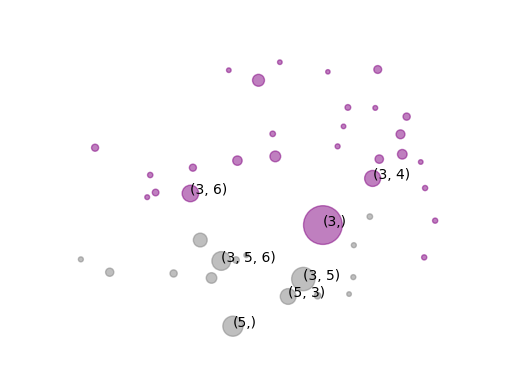

In [23]:
Ballot_MDS_plot(election, C, proxy='Borda', label_threshold=100)

In [32]:
df_p = df[(df['method']=='cast') & (df['proxy']=='HH') & (df['k']==2)].copy()
len(df_p)

205

In [34]:
df_p.columns

Index(['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers', 'score', 'clustering'],
      dtype='object')

In [47]:
# create column of df for Piotr's measurement of polarization (using Cast_HH only)

pol_list = []
for index in df_p.index:
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    full_filename = f"../scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    num_voters = sum(election.values())
    centers = df['centers'][index]
    score2 = df['score'][index]
    
    df1 = df[(df['method']=='cast') & (df['proxy']=='HH') & (df['k']==1) & (df['filename']==filename)]
    score1 = df1['score'].values[0]
    proxy_diameter = (num_cands)*(num_cands -1)/2
    pol = (score1 - score2) / (num_voters*proxy_diameter)
    pol_list.append(pol)

df_p['polarization'] = pol_list

<Axes: xlabel='polarization', ylabel='Count'>

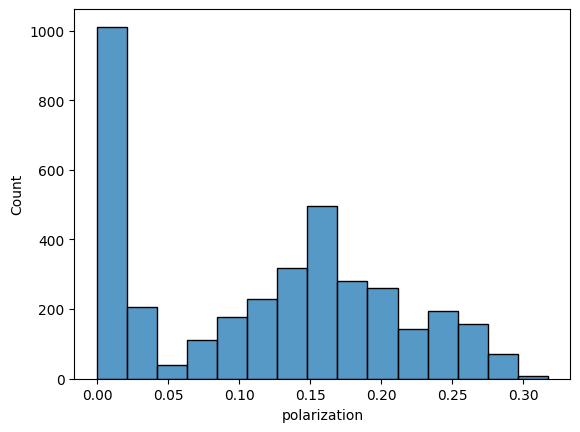

In [49]:
sns.histplot(df['polarization'])

In [50]:
# study a maximally polarized election
M = df_p['polarization'].max()
df_sub = df_p[df_p['polarization'] == M]
df_sub

,filename,num_cands,k,method,proxy,technique,centers,proxies_of_centers,score,clustering,polarization
940,perth_kinross_2022_ward7.csv,6,2,cast,HH,cast_HH,"[(1, 5, 3), (2, 6, 4)]","[[1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 0.0, -1.0, 0....",11587.0,"{0: {(3, 1, 5): 50.0, (1, 5, 3, 2, 4, 6): 3.0,...",0.221087


In [51]:
filename = df_sub['filename'].values[0]
full_filename = f"../scot-elex/6_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)

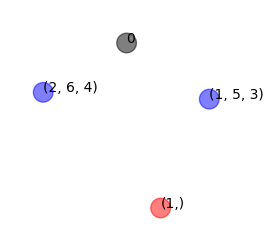

In [52]:
Centers_MDS(filename, method='cast', proxy_type='HH', label_ballots=True)

In [53]:
C = df_sub['clustering'].values[0]

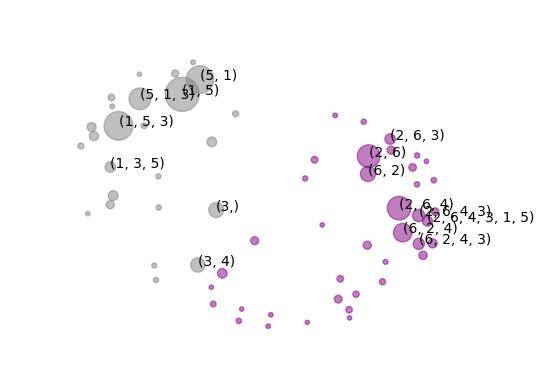

In [55]:
Ballot_MDS_plot(election, C, proxy='HH', label_threshold=50)

In [56]:
# Repeat this for a least polarized election
m = df_p['polarization'].min()
df_sub = df_p[df_p['polarization'] == m]
df_sub

,filename,num_cands,k,method,proxy,technique,centers,proxies_of_centers,score,clustering,polarization
995,sc_borders_2017_ward10.csv,6,2,cast,HH,cast_HH,"[(3, 5), (3,)]","[[0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, ...",9745.0,"{0: {(1, 3, 2, 5, 6, 4): 0.5, (1, 3, 5, 6): 1....",0.048137


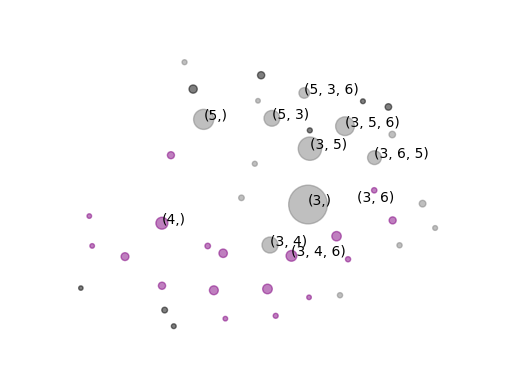

In [57]:
filename = df_sub['filename'].values[0]
full_filename = f"../scot-elex/6_cands/{filename}"
num_cands, election, cand_names, ward = csv_parse(full_filename)
Ballot_MDS_plot(election, C, proxy='HH', label_threshold=50)

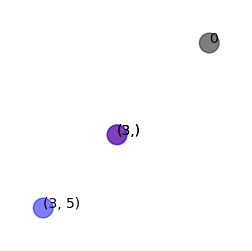

In [58]:
Centers_MDS(filename, method='cast', proxy_type='HH', label_ballots=True)

In [62]:
# add a column to df_p for summed distances
sum_dist_list = []
for index in df_p.index:
    filename = df_p['filename'][index]
    num_cands = df_p['num_cands'][index]
    center2a, center2b = df_p['centers'][index]
    df_sub = df[(df['method']=='cast') & (df['proxy']=='HH') & (df['k']==1) & (df['filename']==filename)]
    center0 = df_sub['centers'].values[0][0]
    d_ab = HH_dist(center2a, center2b, num_cands)
    d_a0 = HH_dist(center2a, center0, num_cands)
    d_b0 = HH_dist(center2b, center0, num_cands)
    sum_dist = min(d_a0 + d_b0) + d_ab
    sum_dist_list.append(sum_dist)
df_p['sum_distances'] = sum_dist_list

TypeError: 'numpy.float64' object is not iterable

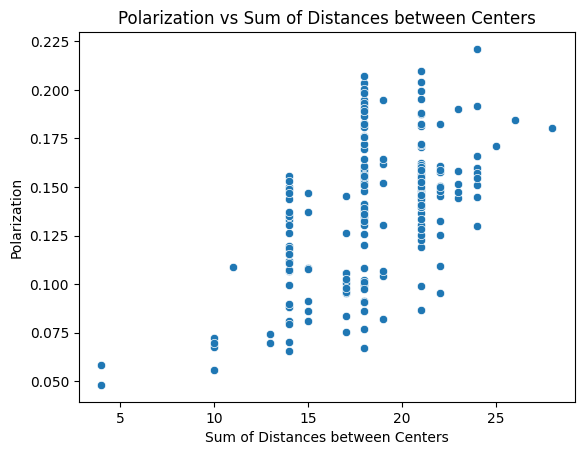

In [63]:
sns.scatterplot(data=df_p, x='sum_distances', y='polarization')
plt.title('Polarization vs Sum of Distances between Centers')
plt.xlabel('Sum of Distances between Centers')
plt.ylabel('Polarization')
plt.show()

In [64]:
df.columns

Index(['filename', 'num_cands', 'k', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers', 'score', 'clustering', 'polarization'],
      dtype='object')